# Circuit transient analysis and eye diagram

This example shows how to create a circuit design,
run a Nexxim time-domain simulation, and create an eye diagram.

Keywords: **Circuit**, **transient**, **eye diagram**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

import ansys.aedt.core
import numpy as np
from matplotlib import pyplot as plt


Define constants.

In [2]:
AEDT_VERSION = "2024.2"
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Launch AEDT with Circuit

Launch AEDT in graphical mode with the Circuit schematic editor.

In [4]:
circuit = ansys.aedt.core.Circuit(
    project=os.path.join(temp_folder.name, "CktTransient"),
    design="Circuit Examples",
    version=AEDT_VERSION,
    new_desktop=True,
    non_graphical=NG_MODE,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_3f961ccb-ec96-422a-9bff-62661e8bb560.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 60525


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 7148.


PyAEDT INFO: Project CktTransient has been created.


PyAEDT INFO: Added design 'Circuit Examples' of type Circuit Design.


PyAEDT INFO: Aedt Objects correctly read


## Place IBIS buffer

Read an IBIS file and place a buffer in the schematic editor.

In [5]:
ibis = circuit.get_ibis_model_from_file(
    os.path.join(circuit.desktop_install_dir, "buflib", "IBIS", "u26a_800.ibs")
)
ibs = ibis.buffers["DQ_u26a_800"].insert(0, 0)

PyAEDT INFO: ModelerCircuit class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: ModelerNexxim class has been initialized!


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


## Place ideal transmission line

Place an ideal transmission line in the schematic and parametrize it.

In [6]:
tr1 = circuit.modeler.components.components_catalog["Ideal Distributed:TRLK_NX"].place(
    "tr1"
)
tr1.parameters["P"] = "50mm"

## Place components

Create a resistor and ground in the schematic.

In [7]:
res = circuit.modeler.components.create_resistor(name="R1", value="1Meg")
gnd1 = circuit.modeler.components.create_gnd()

## Connect componennts

Connect the components in the schematic.

In [8]:
tr1.pins[0].connect_to_component(ibs.pins[0])
tr1.pins[1].connect_to_component(res.pins[0])
res.pins[1].connect_to_component(gnd1.pins[0])

(True,
 <ansys.aedt.core.modeler.circuits.object_3d_circuit.CircuitComponent at 0x1b72cf22f20>)

## Place a probe

Place a voltage probe and rename it to ``Vout``.

In [9]:
pr1 = circuit.modeler.components.components_catalog["Probes:VPROBE"].place("vout")
pr1.parameters["Name"] = "Vout"
pr1.pins[0].connect_to_component(res.pins[0])
pr2 = circuit.modeler.components.components_catalog["Probes:VPROBE"].place("Vin")
pr2.parameters["Name"] = "Vin"
pr2.pins[0].connect_to_component(ibs.pins[0])

(True,
 <ansys.aedt.core.modeler.circuits.object_3d_circuit.CircuitComponent at 0x1b72cf2c0a0>)

## Analyze

Create a transient analysis setup and analyze it.

In [10]:
trans_setup = circuit.create_setup(name="TransientRun", setup_type="NexximTransient")
trans_setup.props["TransientData"] = ["0.01ns", "200ns"]
circuit.analyze_setup("TransientRun")

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Circuit Design correctly changed.


PyAEDT INFO: Solving design setup TransientRun


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Circuit Design correctly changed.


PyAEDT INFO: Design setup TransientRun solved correctly in 0.0h 0.0m 6.0s


True

## Create report

Create a report using the ``get_solution_data()`` method. This
method allows you to view and postprocess results using Python packages.
The ``solutions.plot()`` method uses
[Matplotlib](https://matplotlib.org/).

PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


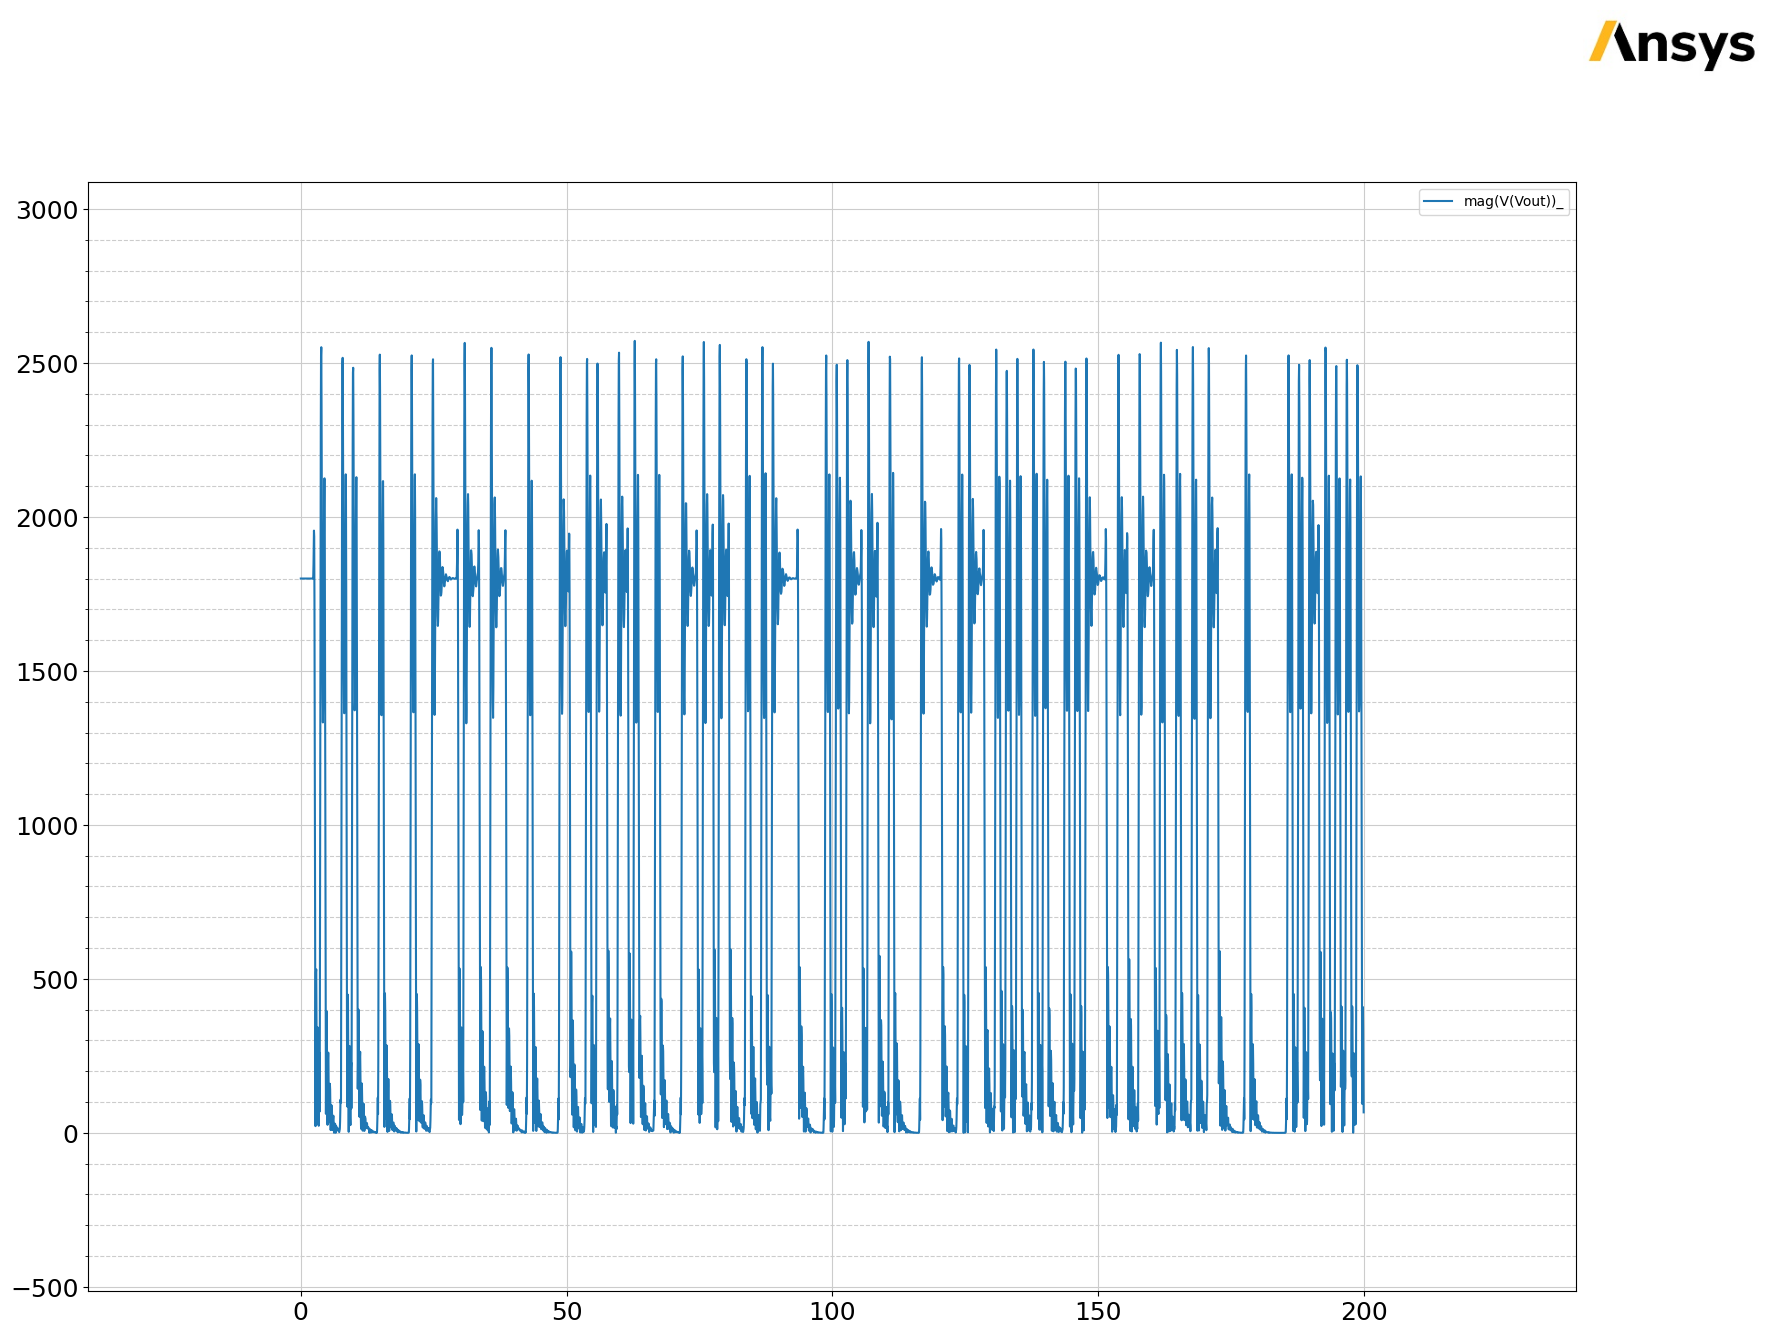

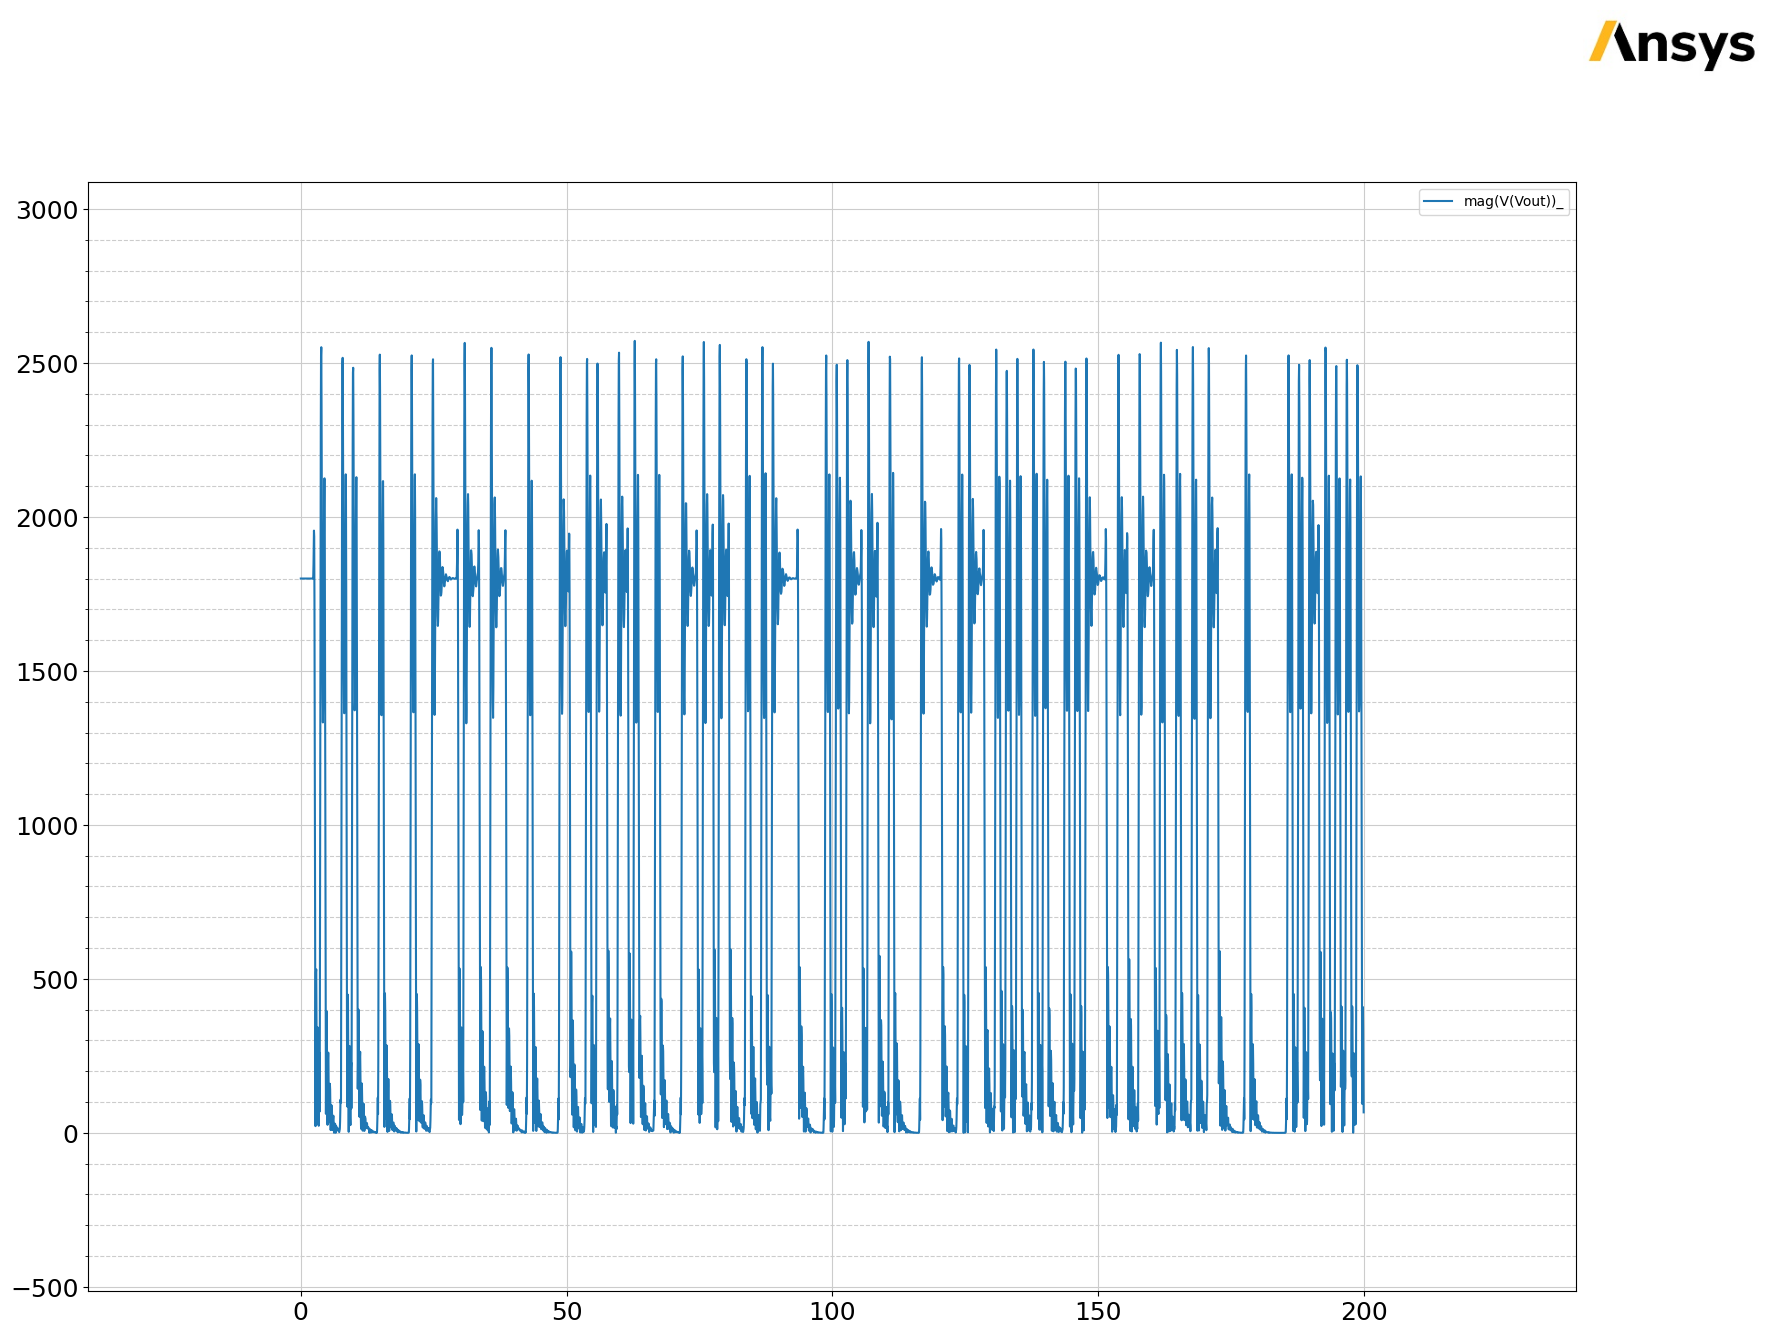

In [11]:
report = circuit.post.create_report("V(Vout)", domain="Time")
if not NG_MODE:
    report.add_cartesian_y_marker(0)
solutions = circuit.post.get_solution_data(domain="Time")
solutions.plot("V(Vout)")

## Visualize results

Create a report inside AEDT using the ``new_report`` object. This object is
fully customizable and usable with most of the reports available in AEDT.
The standard report is the main one used in Circuit and Twin Builder.

PyAEDT INFO: Solution Data Correctly Loaded.


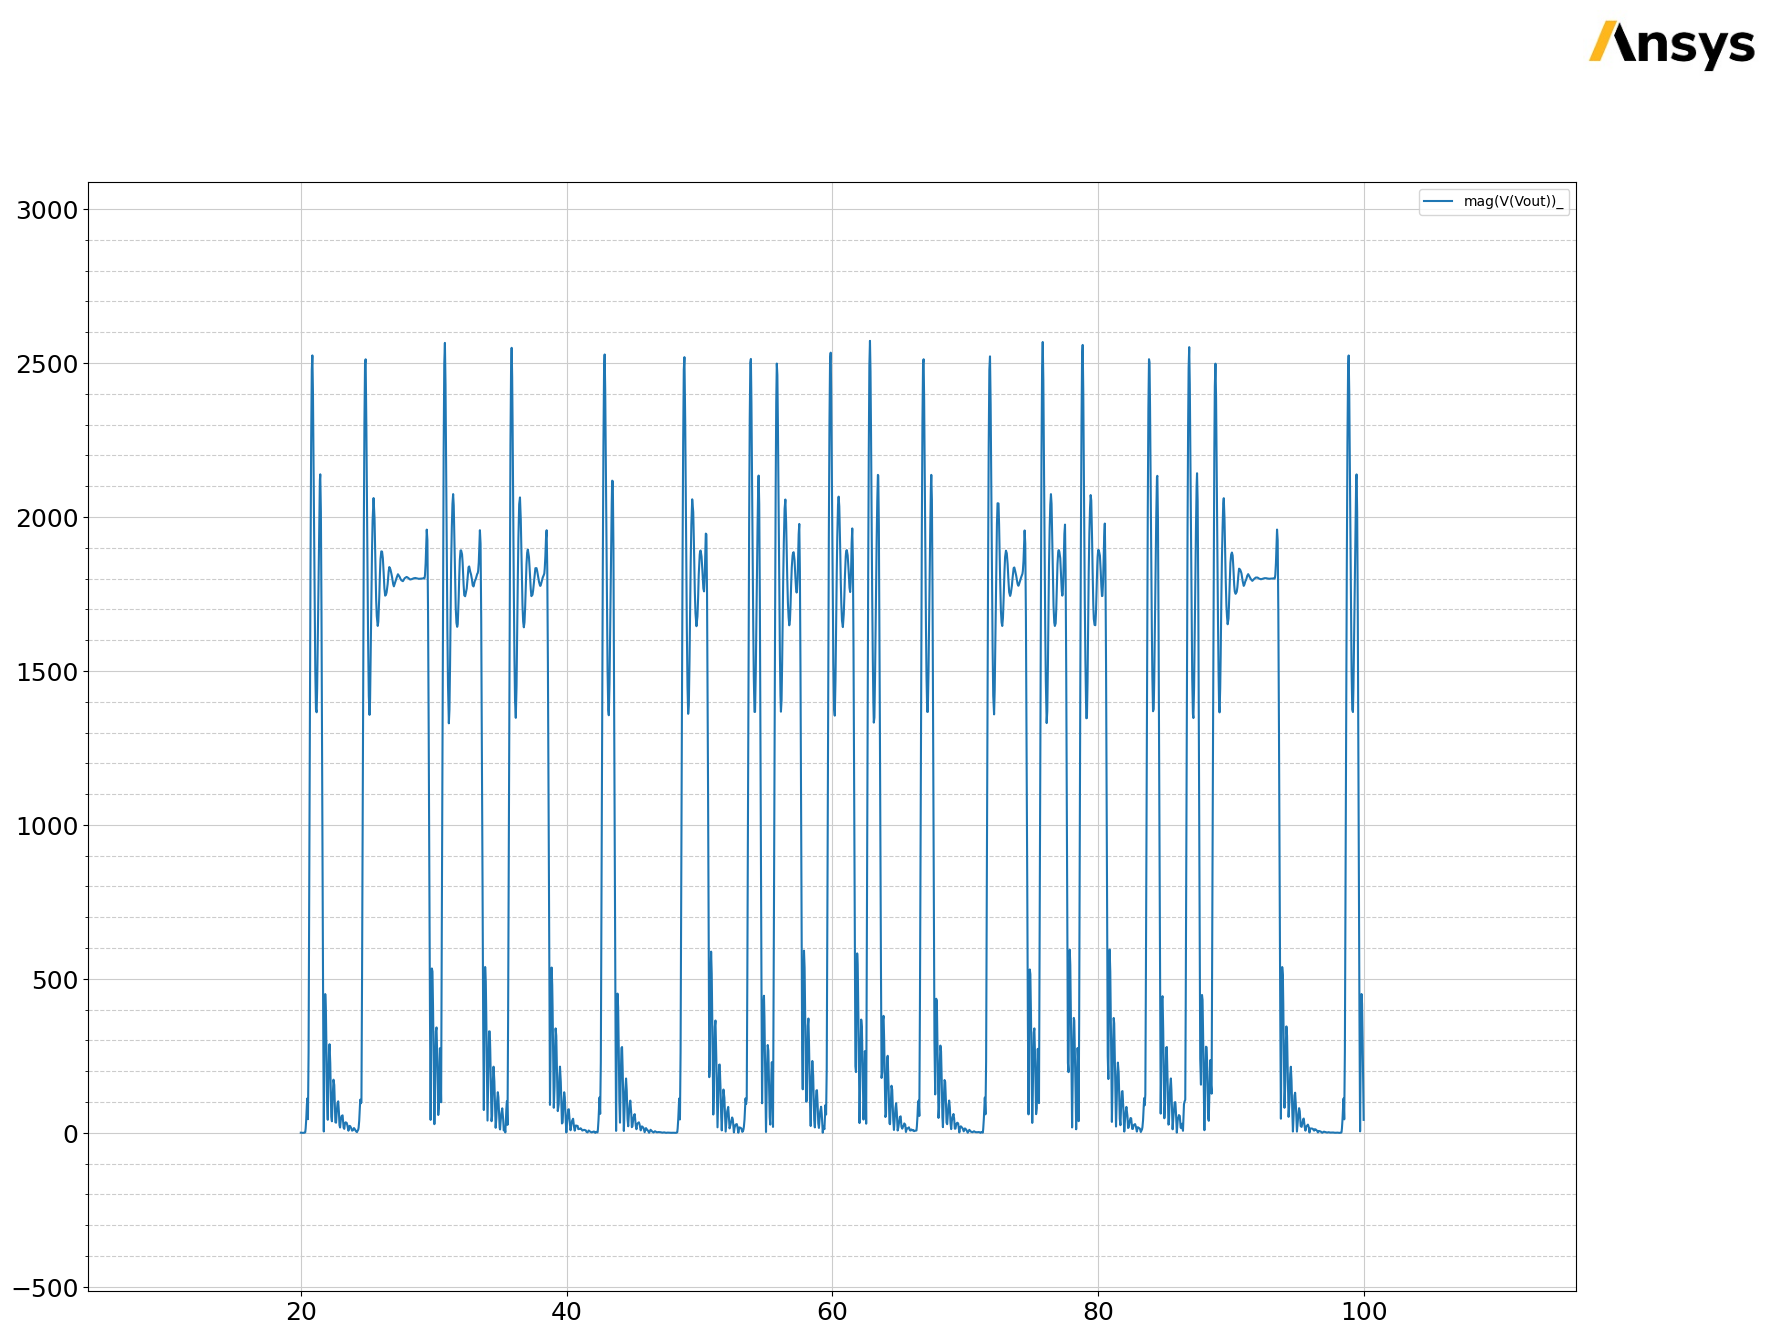

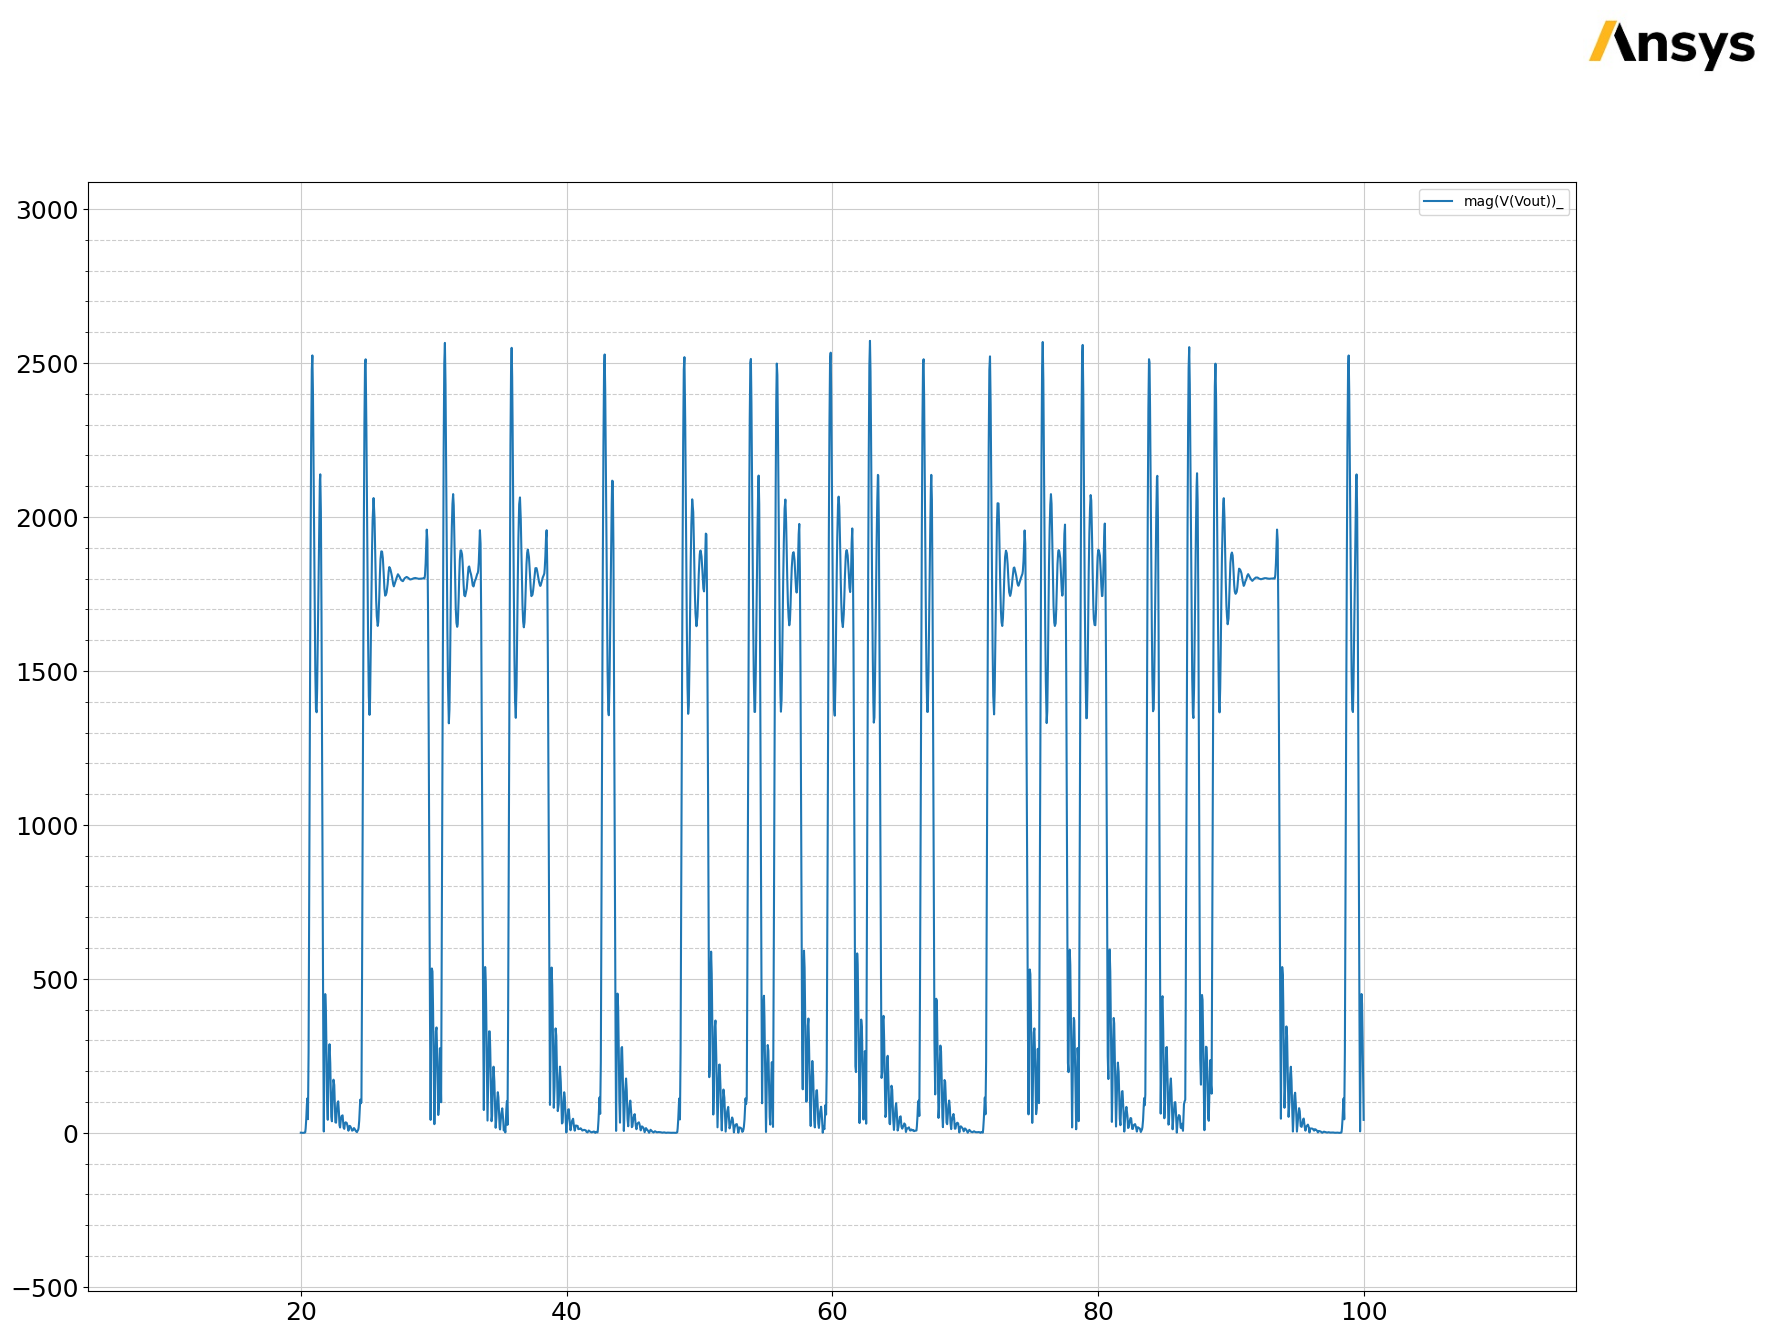

In [12]:
new_report = circuit.post.reports_by_category.standard("V(Vout)")
new_report.domain = "Time"
new_report.create()
if not NG_MODE:
    new_report.add_limit_line_from_points([60, 80], [1, 1], "ns", "V")
    vout = new_report.traces[0]
    vout.set_trace_properties(
        style=vout.LINESTYLE.Dot,
        width=2,
        trace_type=vout.TRACETYPE.Continuous,
        color=(0, 0, 255),
    )
    vout.set_symbol_properties(
        style=vout.SYMBOLSTYLE.Circle, fill=True, color=(255, 255, 0)
    )
    ll = new_report.limit_lines[0]
    ll.set_line_properties(
        style=ll.LINESTYLE.Solid,
        width=4,
        hatch_above=True,
        violation_emphasis=True,
        hatch_pixels=2,
        color=(0, 0, 255),
    )
new_report.time_start = "20ns"
new_report.time_stop = "100ns"
new_report.create()
sol = new_report.get_solution_data()
sol.plot()

## Create eye diagram in AEDT

Create an eye diagram inside AEDT using the ``new_eye`` object.

In [13]:
new_eye = circuit.post.reports_by_category.eye_diagram("V(Vout)")
new_eye.unit_interval = "1e-9s"
new_eye.time_stop = "100ns"
new_eye.create()

PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpsjeidw__.ansys/CktTransient.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpsjeidw__.ansys/CktTransient.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015554666519165039


True

## Create eye diagram in Matplotlib

Create the same eye diagram outside AEDT using Matplotlib and the
``get_solution_data()`` method.

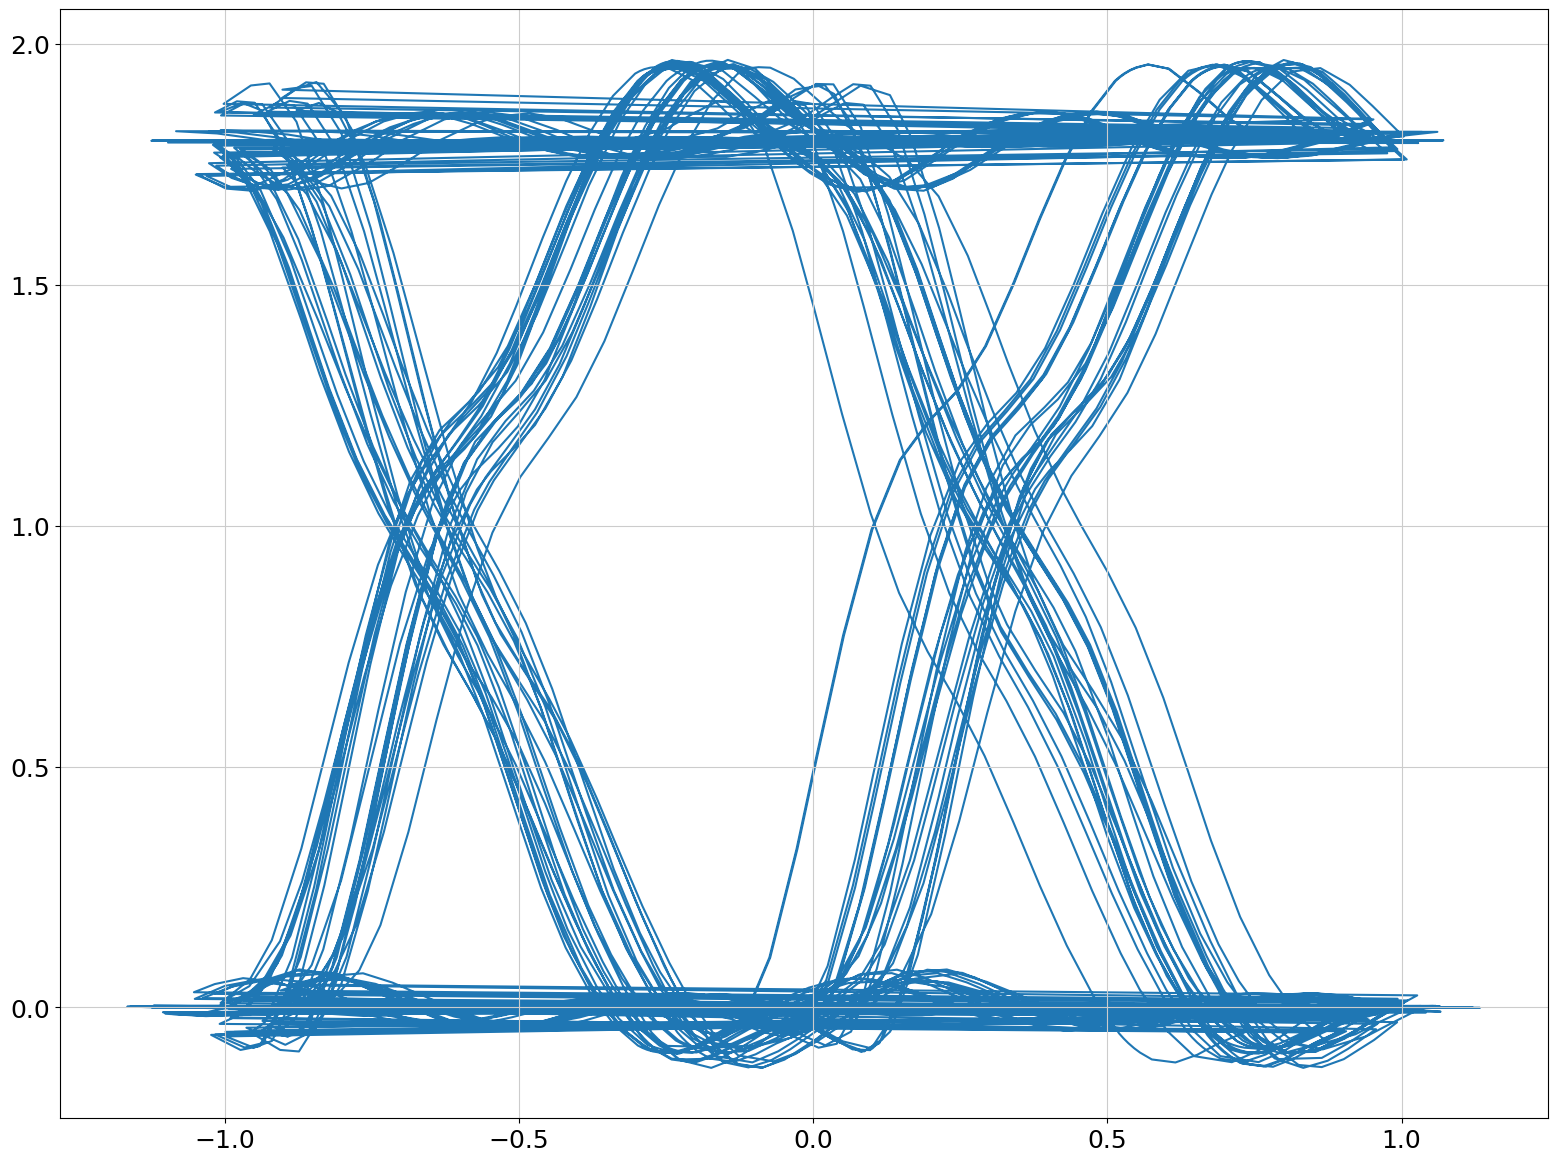

In [14]:
unit_interval = 1
offset = 0.25
tstop = 200
tstart = 0
t_steps = []
i = tstart + offset
while i < tstop:
    i += 2 * unit_interval
    t_steps.append(i)

t = [
    [i for i in solutions.intrinsics["Time"] if k - 2 * unit_interval < i <= k]
    for k in t_steps
]
ys = [
    [
        i / 1000
        for i, j in zip(solutions.data_real(), solutions.intrinsics["Time"])
        if k - 2 * unit_interval < j <= k
    ]
    for k in t_steps
]
fig, ax = plt.subplots(sharex=True)
cells = np.array([])
cellsv = np.array([])
for a, b in zip(t, ys):
    an = np.array(a)
    an = an - an.mean()
    bn = np.array(b)
    cells = np.append(cells, an)
    cellsv = np.append(cellsv, bn)
plt.plot(cells.T, cellsv.T, zorder=0)
plt.show()

## Release AEDT

Release AEDT and close the example.

In [15]:
circuit.save_project()
circuit.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project CktTransient Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``. If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes all temporary files, including the project folder.

In [16]:
temp_folder.cleanup()